In [1]:
# modules importation
from trends_functions import *
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# computation parameters
params = get_params()

In [3]:
# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'concpm10' 'concpm25' 'concso4' 'scatc550dryaer' 'absc550aer'
var = 'scatc550dryaer'
params['kind'] = 'obs'
fill_params(params, var)
#if var in ['scatc550dryaer', 'absc550aer']:
#    params['period'] = '2000-2018'
params['var'] = var
obs_source = params['source']
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)

In [4]:
_, OBS_MAP, OBS_DF = process_trend(
    obs_data, params,
    plot=False, show_plot=False, save_plot=False, write_json=False
)

excluding module
exclude  Ispra
exclude  Montseny
excluding modulestation:  Vavihillmospheric Research Observatoryt
region:  ASIA station:  Gosanon-do
Less than 7 points in selected period
excluding module
excluding moduleA station:  Wichita Mountainsderness3ain #1ment (GA09)WA99)5)
excluding moduleA station:  Cape San Juan
exclude  Granada
region:  NAFRICA station:  Finokaliaillo
Less than 7 points in selected period
excluding module
No station found in , AUSTRALIA Point
excluding module
exclude  Granada
exclude  Ispra
exclude  Montseny


In [5]:
MOD_MAP, MOD_DF = {}, {}

# run models
#'GFDL-AM4-amip_HIST' if var == 'od550lt1aer' || var == 'od550gt1aer' || 
mod_var = var
params['kind'] = 'mod'

all_mods = list(get_all_mods().keys())

#for the models, set mon_dim to zero
params['min_dim'] = 0
#params['min_ntrend'] = 4
mod_var = params['mod_var']

#mod_sources = sources[var]
mod_sources = params['models']

for mod_source in mod_sources:
    params['source'] = mod_source
    
    #check if model in cache
    fn = 'cache/'+mod_source+'_'+var+'.pkl'
    if os.path.isfile(fn):
        print(mod_source,'use pickle')
        # for reading also binary mode is important 
        pklfile = open(fn, 'rb')      
        mod_data = pickle.load(pklfile) 
        pklfile.close()
    else:
        print(mod_source,'read netcdf data')
        reader = pya.io.ReadGridded(mod_source)
        if (var=='scatc550dryaer'):
            mod_data = reader.read_var(mod_var, ts_type='daily', aux_fun=pya.io.aux_read_cubes.subtract_cubes, aux_vars=['ec550dryaer', 'absc550aer'])
        else:
            mod_data = reader.read_var(mod_var, ts_type='daily')
        
        #if cube has 4 dimensions, extract first level
        if mod_var in ['concso4', 'concpm10', 'concpm25', 'scatc550dryaer', 'absc550aer'] and len(np.shape(mod_data))==4:
            print('cube has 4 dimension, extract first layer')
            mod_data = mod_data.extract_surface_level()
        
        mod_data = mod_data.resample_time(to_ts_type='monthly')

        #write picke file in cache directory
        pklfile = open(fn, 'ab') 

        try:
            # source, destination 
            pickle.dump(mod_data, pklfile)                      
            pklfile.close()
        except AttributeError:
            print('AttributeError')
            os.remove(fn)

    if type(mod_data)==float:
        MOD_MAP[mod_source] = {}
    else:
        #crop the cube to interest period, so can handle WORLD region
        mod_data = mod_data.crop(time_range=(params['period'].split('-')[0], str(int(params['period'].split('-')[1])+1)))
        #check time frequency, if 5 years, set #params['min_ntrend'] = 0
        years = [ts.item().year for ts in mod_data.time_stamps()]
        uyears = np.unique(years)
        i2000 = np.argmin(abs(uyears-2000))
        dy = uyears[i2000+1]-uyears[i2000]
        if dy>=1:
            params['min_ntrend'] = 4
        else:
            params['min_ntrend'] = 7
        
        #full colocation
        _, MOD_MAP[mod_source], MOD_DF[mod_source], = process_trend(
            mod_data, params, obs=obs_data,
            colocate_time=True, colocate_space=True,
            OBS_DF = OBS_DF,
            plot=False, show_plot=False, save_plot=False, write_json=False
        )

NorESM2-CPL-NEWTEST_HIST read netcdf data
cube has 4 dimension, extract first layer
AttributeError
colocate monthly dataframesavihillmospheric Research Observatoryt
colocate monthly dataframes Wichita Mountainsderness3ain #1ment (GA09)WA99)5)
No station found in  AUSTRALIA
colocate monthly dataframesppelin mountain (Ny-Ålesund)1rvatoryA09)WA99)5)


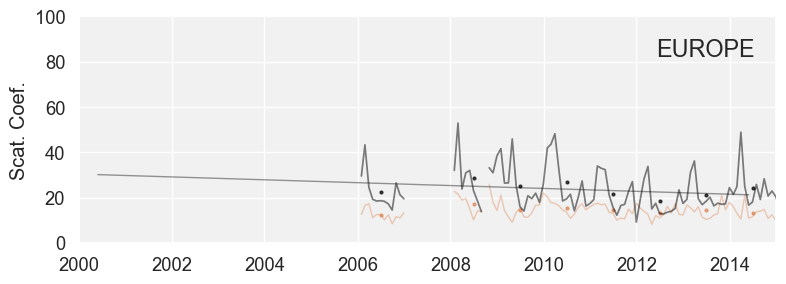

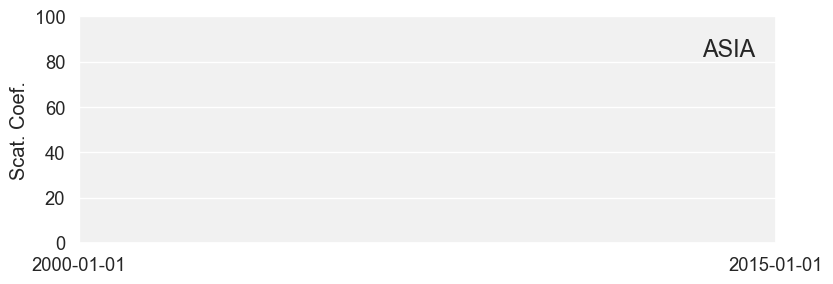

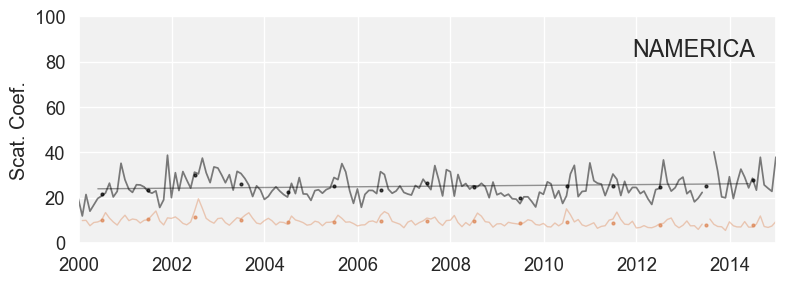

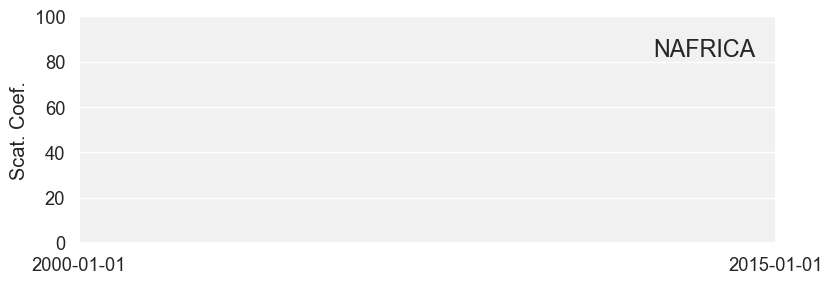

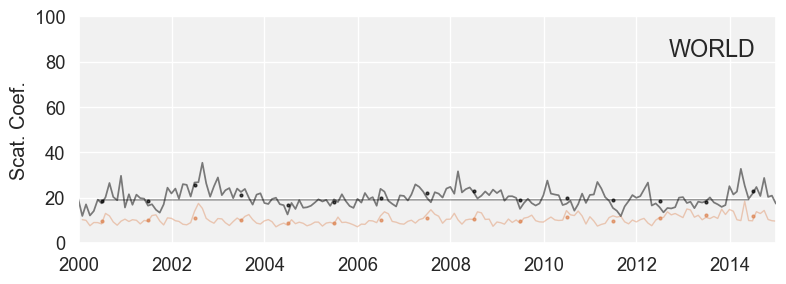

In [6]:
#for region in OBS_MAP.keys():
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
typlot = 'ts' #'vlts' #very long time series
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.2
sns.set(font_scale=fscale)
#prepare colors
current_palette = sns.color_palette("deep")
regions = get_regions()
for nfig, region in enumerate(regions):
    
    #check if observations in the region
    if region in OBS_MAP and OBS_MAP[region]['trends']:
        #open the figure
        fig, ax = plt.subplots(figsize=(9, 3), dpi=100, facecolor='w', edgecolor='k')
    
        #OBS time series
        xm = js2date(OBS_MAP[region]['trends']['monthly']['jsdate'])
        ym = OBS_MAP[region]['trends']['monthly']['data']
        xy = js2date(OBS_MAP[region]['trends']['yearly']['jsdate'])
        yy = OBS_MAP[region]['trends']['yearly']['data']

        #OBS trends
        trend = OBS_MAP[region]['trends']['trends']
        for nseg, seg in enumerate(trend.keys()):
            rel_slp = trend[seg]['rel_slp']
            pval = trend[seg]['pval']
            xt = js2date(trend[seg]['jsdate'])
            yt = trend[seg]['data']

            #plot the observations
            plt.sca(fig.axes[0])
            color = 'black'
            if nseg==0:
                if typlot != 'vlts':
                    plt.plot(xm, ym, color=color, linestyle='-', linewidth=1.25, alpha=0.5, zorder=100, label='OBS')
                plt.plot(xy, yy, color=color, marker='o', linewidth=0, markersize=2, alpha=0.7, zorder=100)
            plt.plot(xt, yt, color=color, alpha=0.4, linewidth=1, zorder=100)

            #draw vertical line if several segments
            if nseg > 0:
                plt.axvline(x=xt[0], ls=':', lw=2, color=(.5, .5, .5), alpha=.6)

            if len(MOD_MAP.keys())>0:
                #MOD time series
                rel_slps = [rel_slp]
                colors = [color]
                if nseg==0:
                    for i, mod_source in enumerate(mod_sources):
                        if region in MOD_MAP[mod_source] and 'monthly' in MOD_MAP[mod_source][region]['trends']:
                            xm = js2date(MOD_MAP[mod_source][region]['trends']['monthly']['jsdate'])
                            ym = MOD_MAP[mod_source][region]['trends']['monthly']['data']
                            xy = js2date(MOD_MAP[mod_source][region]['trends']['yearly']['jsdate'])
                            yy = MOD_MAP[mod_source][region]['trends']['yearly']['data']

                            #MOD trends
                            mod_trend = MOD_MAP[mod_source][region]['trends']['trends']
                            mod_keys= list(mod_trend.keys())
                            if len(mod_keys)>0:
                                mod_seg = mod_keys[nseg]
                                if mod_seg in mod_keys:
                                    rel_slp = mod_trend[mod_seg]['rel_slp']
                                    if rel_slp!=None:
                                        rel_slps.append(rel_slp)
                                    else:
                                        rel_slps.append(np.nan)
                                    pval = mod_trend[mod_seg]['pval']
                                    xt = js2date(mod_trend[mod_seg]['jsdate'])
                                    yt = mod_trend[mod_seg]['data']

                                    color = get_color_mod(mod_source)
                                    colors.append(color)
                                    if typlot != 'vlts':
                                        plt.plot(xm, ym, color=color, linewidth=1.0, alpha=0.4, zorder=i+1, label = mod_source)
                                    plt.plot(xy, yy, color=color, marker='o', linewidth=0, markersize=2, alpha=0.7, zorder=i+1)
                                    #plt.plot(xt, yt, color=color, alpha=0.2, linewidth=1, label = mod_source, zorder=i+1)
                                else:
                                    rel_slps.append(np.nan)
                                    colors.append(color)
                            else:
                                rel_slps.append(np.nan)
                                colors.append(color)
                        else:
                            rel_slps.append(np.nan)
                            colors.append(color)

        #add info in main axis
        plt.sca(fig.axes[0])
        ax = fig.axes[0]
        #ax.set_title(region+' '+period)

        if params['ylabel'] != None:
            ax.set_ylabel(params['ylabel'])
        if params['ymin'] != None:
            plt.ylim(bottom=params['ymin'])
        if params['ymax'] != None:
            plt.ylim(top=params['ymax'])

        # write region at top-right
        ax.text(.97, .85, region, horizontalalignment='right', verticalalignment='center',
                transform=ax.transAxes, fontsize=14 * fscale, zorder=100)
        #ax.set_xlim([datetime.date(1995, 1, 1), datetime.date(2018, 12, 31)])
        if typlot == 'vlts':
            ax.set_xlim([datetime.date(1850, 1, 1), datetime.date(2018, 12, 31)])
        else:
            ax.set_xlim(params['period'].split('-')[0]+'-01-01',str(int(params['period'].split('-')[1])+1)+'-01-01')
        
        ax.set_facecolor('#F1F1F1')
        plt.savefig('figs/ts/ALL/' + obs_source + '-' + params['var'] + '-' +
                    region + '.png', dpi=300, bbox_inches='tight')

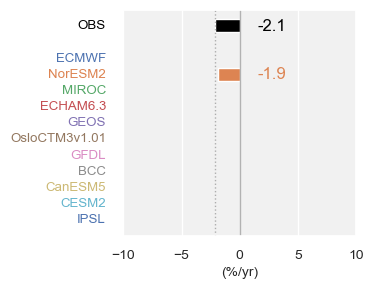

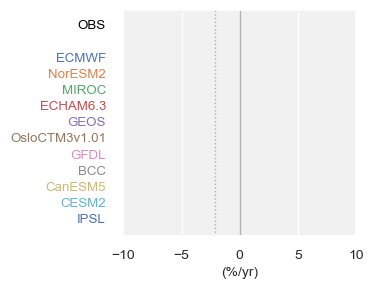

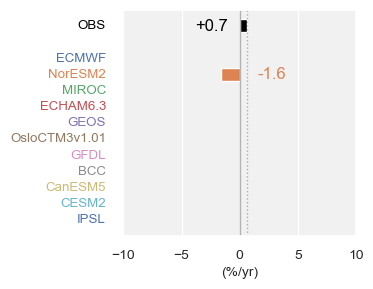

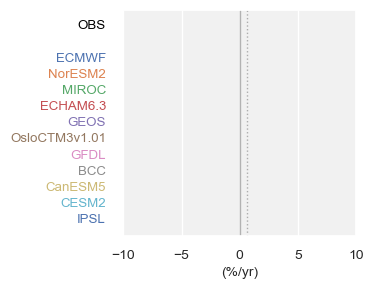

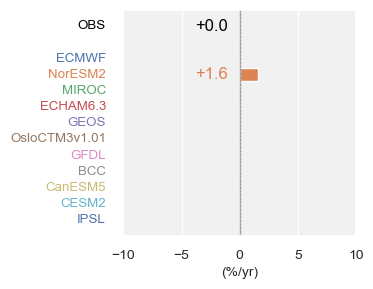

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.2
sns.set(font_scale=fscale)
#prepare colors
current_palette = sns.color_palette("deep")
#sns.palplot(current_palette)
regions = get_regions()

for nfig, region in enumerate(regions):
    #check if observations in the region
    if region in OBS_MAP and 'monthly' in OBS_MAP[region]['trends']:
        #open the figure
        # plot that
        fig, ax = plt.subplots(figsize=(3, 3), dpi=100,
                               facecolor='w', edgecolor='k')
    
        xm = js2date(OBS_MAP[region]['trends']['monthly']['jsdate'])
        ym = OBS_MAP[region]['trends']['monthly']['data']
        xy = js2date(OBS_MAP[region]['trends']['yearly']['jsdate'])
        yy = OBS_MAP[region]['trends']['yearly']['data']

        #trends
        trend = OBS_MAP[region]['trends']['trends']
        for nseg, seg in enumerate(trend.keys()):
            rel_slp = trend[seg]['rel_slp']
            pval = trend[seg]['pval']
            xt = js2date(trend[seg]['jsdate'])
            yt = trend[seg]['data']

            color = 'black'
            #add the models
            rel_slps = [rel_slp]
            colors = [color]
            if len(MOD_MAP.keys())>0:
                for i, mod_source in enumerate(all_mods):
                    color = get_color_mod(mod_source)
                    if mod_source in MOD_MAP and region in MOD_MAP[mod_source]:
                        xm = js2date(MOD_MAP[mod_source][region]['trends']['monthly']['jsdate'])
                        ym = MOD_MAP[mod_source][region]['trends']['monthly']['data']
                        xy = js2date(MOD_MAP[mod_source][region]['trends']['yearly']['jsdate'])
                        yy = MOD_MAP[mod_source][region]['trends']['yearly']['data']

                        #trends
                        mod_trend = MOD_MAP[mod_source][region]['trends']['trends']
                        mod_keys= list(mod_trend.keys())
                        if len(mod_keys)>nseg:
                            mod_seg = mod_keys[nseg]
                            if mod_seg in mod_keys:
                                rel_slp = mod_trend[mod_seg]['rel_slp']
                                if rel_slp!=None:
                                    rel_slps.append(rel_slp)
                                else:
                                    rel_slps.append(np.nan)
                                pval = mod_trend[mod_seg]['pval']
                                xt = js2date(mod_trend[mod_seg]['jsdate'])
                                yt = mod_trend[mod_seg]['data']
                                colors.append(color)
                            else:
                                rel_slps.append(np.nan)
                                colors.append(color)
                        else:
                            rel_slps.append(np.nan)
                            colors.append(color)
                    else:
                        rel_slps.append(np.nan)
                        colors.append(color)


            ticks = ['OBS']
            y_pos = [0+0.4*nseg]
            heights = [0.8]
            # loop over all the models, so each model stays at each level
            for i, mod in enumerate(all_mods):
                if all_mods[i] in mod_sources:
                    ticks.append(all_mods[i])
                    y_pos.append(2+i+0.4*nseg) #the first tick is allocated to OBS
                    heights.append(0.8)
                else:
                    ticks.append(all_mods[i])
                    y_pos.append(2+i+0.4*nseg) #the first tick is allocated to OBS
                    heights.append(np.nan)
                    
            #y_pos = [0+0.4*nseg]
            #y_pos.extend(np.arange(len(rel_slps)-1)+2+0.4*nseg)
            #height = [0.8]
            #height.extend(0.8*np.ones(len(rel_slps)-1))
            heights = [h/len(list(trend.keys())) for h in heights]
            
            ax.barh(y_pos, rel_slps, color=colors, height=heights, alpha=1-0.5*nseg)

            #write slope and source
            for i, rel_slp in enumerate(rel_slps):
                if np.sign(rel_slp)>0:
                    dx = 3
                else:
                    dx = 0
                if not np.isnan(rel_slp):
                    if len(trend.keys())>1:
                        fs = 9
                    else:
                        fs = 10
                    ax.text(-np.sign(rel_slp)*4+dx, y_pos[i], '{:+3.1f}'.format(rel_slp), horizontalalignment='right', verticalalignment='center',
                        transform=ax.transData, fontsize=fs*fscale, zorder=100, color=colors[i])


        #plot a vertical line at the zero value
        plt.axvline(x=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        #plot a vertical line at the observation level
        plt.axvline(x=rel_slps[0], ls=':', lw=1, color=(.5, .5, .5), alpha=.6)

        #ax.set_yticks(y_pos)
        #ax.set_yticklabels(ticks)
        ax.set_xlim(-10,10)
        ax.set_ylim(-1,len(all_mods)+2)
        #if nseg==0:

        ax.invert_yaxis()  # labels read top-to-bottom
            
        ax.tick_params(labelsize=10)
        ax.set_xlabel('(%/yr)', fontsize=10)
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.axes.get_yaxis().set_visible(False)

        
        #plot labels to the right in different colors
        #prepare left axis
        ticks = ['OBS']
        #ticks.extend(mod_sources)
        y_pos = [0+0.4*nseg]
        height = [0.8]
        # loop over all the models, so each model stays at right level
        for i, mod in enumerate(all_mods):
            ticks.append(all_mods[i])
            y_pos.append(2+i+0.4*nseg) #the first tick is allocated to OBS
            height.append(0.8)

        #write slope and source
        for i, _ in enumerate(ticks):
            tick = ticks[i]
            if tick=='OBS':
                color = 'black'
            else:
                color = colors[i]
            tick = tick.split('_')[0]
            tick = tick.split('-')[0]
            ax.text(-0.075, (len(y_pos)+1-y_pos[i])/(len(y_pos)+2), tick, horizontalalignment='right', verticalalignment='center',
                transform=ax.transAxes, fontsize=8 * fscale, zorder=100, color=color)
        
        #plt.title(region)
        ax.set_facecolor('#F1F1F1')
        plt.savefig('figs/bars/' + obs_source + '-' + params['var'] + '-' +
                    region + '.png', dpi=300, bbox_inches='tight')

In [8]:
head = ['Region', 'Segment', 'OBS']
head.extend(mod_sources)
print(*head)
tab, tab2, tab3 = [], [], []
for region in regions:
    #get segments
    if region in OBS_MAP and 'trends' in OBS_MAP[region] and 'trends' in OBS_MAP[region]['trends']:
        segments = list(OBS_MAP[region]['trends']['trends'])
        for nseg, segment in enumerate(segments):
            rel_slps = []
            pvals = []
            errs = []
            obs_slp = round(OBS_MAP[region]['trends']['trends'][segment]['rel_slp'],2)
            obs_pval = round(OBS_MAP[region]['trends']['trends'][segment]['pval'],2)
            obs_err = round(OBS_MAP[region]['trends']['trends'][segment]['err_rel_slp'],2)

            #mod trends
            for i, mod_source in enumerate(mod_sources):
                if region in MOD_MAP[mod_source]:
                    #trends
                    mod_trend = MOD_MAP[mod_source][region]['trends']['trends']
                    mod_keys= list(mod_trend.keys())
                    if len(mod_keys)>nseg:
                        mod_seg = mod_keys[nseg]
                        if mod_seg in mod_keys:
                            rel_slp = mod_trend[mod_seg]['rel_slp']
                            pval = mod_trend[mod_seg]['pval']
                            err = mod_trend[mod_seg]['err_rel_slp']
                            if rel_slp!=None:
                                rel_slps.append(round(rel_slp,2))
                                pvals.append(pval)
                                errs.append(round(err,2))
                            else:
                                rel_slps.append(np.nan)
                                pvals.append(np.nan)
                                errs.append(np.nan)
                        else:
                            rel_slps.append(np.nan)
                            pvals.append(np.nan)
                            errs.append(np.nan)
                    else:
                        rel_slps.append(np.nan)
                        pvals.append(np.nan)
                        errs.append(np.nan)
                else:
                        rel_slps.append(np.nan)
                        pvals.append(np.nan)
                        errs.append(np.nan)

            print(region, segment, round(obs_slp, 2), *rel_slps)
            tab.append([params['ylabel'], region, segment, round(obs_slp, 2), *rel_slps])
            tab2.append([params['ylabel'], region, segment, round(obs_pval, 2), *pvals])
            tab3.append([params['ylabel'], region, segment, round(obs_err, 2), *errs])
            
            
head_df = ['Parameter']
head_df.extend(head)
df = pd.DataFrame(tab, columns=head_df).set_index(['Parameter', 'Region', 'Segment'])
df2 = pd.DataFrame(tab2, columns=head_df).set_index(['Parameter', 'Region', 'Segment'])
df3 = pd.DataFrame(tab3, columns=head_df).set_index(['Parameter', 'Region', 'Segment'])

#write dataframe
pklfile = open('cache/rslp/'+var+'.pkl', 'wb')
# source, destination 
pickle.dump(df, pklfile)                      
pklfile.close()

#write dataframe
pklfile = open('cache/pval/'+var+'.pkl', 'wb')
# source, destination 
pickle.dump(df2, pklfile)                      
pklfile.close()

#write dataframe
pklfile = open('cache/err/'+var+'.pkl', 'wb')
# source, destination 
pickle.dump(df3, pklfile)                      
pklfile.close()

Region Segment OBS NorESM2-CPL-NEWTEST_HIST
EUROPE 2000-2014 -2.11 -1.85
NAMERICA 2000-2014 0.67 -1.58
WORLD 2000-2014 0.03 1.6


### debug process_trend